In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import HTML
from pydrake.math import sin, cos

%matplotlib inline

from pydrake.all import (SignalLogger, CompliantMaterial, ConstantVectorSource, DirectCollocation, DiagramBuilder, FloatingBaseType,
                         PiecewisePolynomial, RigidBodyTree, RigidBodyPlant,
                         SolutionResult, AddModelInstancesFromSdfString,
                         MathematicalProgram, Simulator, BasicVector, AddFlatTerrainToWorld)
from underactuated import (FindResource, PlanarRigidBodyVisualizer)

import time
import random

from matplotlib import animation

In [4]:
# let's use Meshcat!
# CHANGE THIS DIRECTOR TO AVOID REBUILDING
# import os
# my_dir = '/Users/ethanweber/Documents/RobotLocomotionGroup/meshcat-python'
# os.chdir(my_dir+'/src')

import meshcat
import meshcat.geometry as g
import meshcat.transformations as tf

In [24]:
vis = meshcat.Visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7005/static/


In [30]:
corner = vis["corner"]
cube = corner["cube"]
pivot = cube["pivot"]
wheel = pivot["wheel"]

In [36]:
corner.set_transform(tf.translation_matrix([0,0,0]))

# create and draw the cube
cube_dim = [1.0,1.0,1.0] # x,y,z
cube.set_object(g.Box(cube_dim))
cube.set_transform(tf.translation_matrix([0,0.5,0.5]))

# pivot and wheel
pivot.set_transform(tf.translation_matrix([0,0,0])) # set location of pole
wheel_dim = [1.5,.5,.5] # x,y,z
wheel.set_object(g.Box(wheel_dim))

theta = 0.5
val = tf.rotation_matrix(-theta,[1,0,0])
corner.set_transform(val)

wheel_angle = 0.5
wheel.set_transform(tf.rotation_matrix(-wheel_angle,[1,0,0])) # rotate the pole


In [53]:
def draw_transformation(state):
    theta = state[0]
    val = tf.rotation_matrix(-theta+np.pi/4.0,[1,0,0])
    corner.set_transform(val)

    wheel_angle = state[1]
    wheel.set_transform(tf.rotation_matrix(-wheel_angle,[1,0,0])) # rotate the pole

In [54]:
initital_state = (0.0,0.,0.,0.)
draw_transformation(initital_state)

In [101]:
# state (theta_cube, theta_wheel, thetadot_cube, thetadot_wheel)
def pivot_dynamics(state, u, force):
    
    l = 0.085
    l_b = 0.075
    m_b = 0.419
    m_w = 0.204
    I_b = 3.34 * 10**(-3)
    I_w = 0.57 * 10**(-3)
    C_b = 1.02 * 10**(-3)
    C_w = 0.05 * 10**(-3)
    
    
    theta_b = state[0]
    theta_w = state[1]
    thetadot_b = state[2]
    thetadot_w = state[3]
    
    g = 9.81
    
    # set the derivatives
    derivs = np.zeros_like(state)
    derivs[0:2] = state[2:]
    
    # thetadot_cube
    derivs[2] = l*(force[0] - force[1]) + \
    ((m_b*l_b+m_w*l)*g*sin(theta_b)-u[0]-C_b*thetadot_b+C_w*thetadot_w)/(I_b+m_w*(l**2))
    
    derivs[3] = (I_b+I_w+m_w*(l**2))*(u[0]-C_w*thetadot_w)/(I_w*(I_b+m_w*(l**2))) \
    - ((m_b*l_b+m_w*l)*g*sin(theta_b) - C_b*thetadot_b)/(I_b+m_w*(l**2))
    
    return derivs

In [162]:
def compute_optimal_control(initial_state, final_state, min_time, max_time, max_torque):

# Setup solver
    mp = MathematicalProgram()

# number knot points
    N = 50
    
# Total time used
    time_used = mp.NewContinuousVariables(1, "time_used") # add random variabe for time used
    dt = time_used/(N+1)
    
# Control decision variables
    u = mp.NewContinuousVariables(1, "u_%d" % 0) # only one input for the cube
    u_over_time = u
    for k in range(1,N):
        u = mp.NewContinuousVariables(1, "u_%d" % k)
        u_over_time = np.vstack((u_over_time, u))
    total_u = u_over_time
    
# Force decision variables
    f = mp.NewContinuousVariables(2, "f_%d" % 0) # only one input for the cube
    f_over_time = f
    for k in range(1,N):
        f = mp.NewContinuousVariables(2, "f_%d" % k)
        f_over_time = np.vstack((f_over_time, f))
    total_f = f_over_time

# State decision variables
    x = mp.NewContinuousVariables(4, "x_%d" % 0) # for both input thrusters
    x_over_time = x
    for k in range(1,N+1):
        x = mp.NewContinuousVariables(4, "x_%d" % k)
        x_over_time = np.vstack((x_over_time, x))
    total_x = x_over_time
    
# State Constraints
    error_thresh = 0.01
    for n in range(N):
        # Actual state vs. predicted (through dynamics) state
        state_next = total_x[n+1]
        dynamic_state_next = total_x[n,:] + pivot_dynamics(total_x[n,:], total_u[n,:], total_f[n,:])*dt
        
        # Make sure the actual and predicted align to follow dynamics
        for j in range(4):
            state_error = state_next[j] - dynamic_state_next[j]
            mp.AddConstraint(state_error <= error_thresh)
            mp.AddConstraint(state_error >= -error_thresh)
        
# Can't penitrate the floor and can't leave the floor
    for n in range(N):
        state = total_x[n,:]
        
        # the floor is at -.5
#         floor_offset = -.01
        mp.AddConstraint(state[0] >= -np.pi/4.0)
        mp.AddConstraint(state[0] <= np.pi/4.0)
        
# Ground forces can't pull on the ground
    max_force = 100
    for n in range(N):
        force = total_f[n]
        for j in range(2):
            mp.AddConstraint(force[j] <= max_force)
            mp.AddConstraint(force[j] >= 0)
    
# add complimentary constraint
    for n in range(N):
        force = total_f[n]
        state = total_x[n]
        theta = state[0]
        
        dist_vals = [np.pi/4.0 - theta, np.pi/4.0 + theta]
        distances = np.asarray(dist_vals)
        
        
        vector_0 = force[0]
        vector_1 = force[1]
        
        val = np.asarray([vector_0, vector_1])

        thresh = 0.0001
        mp.AddConstraint(val.dot(distances) <= thresh)
        mp.AddConstraint(val.dot(distances) >= -thresh)
    
    
# cost
#     mp.AddQuadraticCost(1 * u_over_time[:,0].dot(u_over_time[:,0]))
#     for i in range(8):
#         mp.AddQuadraticCost(1 * f_over_time[:,i].dot(f_over_time[:,i]))


# initial state
    for i in range(4):
        # initial
        initial_state_error = x_over_time[0,i] - initial_state[i]
        mp.AddConstraint(initial_state_error == 0.0)

# don't care about final wheel angle
    error_thresh = 0.01
    for i in [0,2,3]:
        # final
        final_state_error = x_over_time[-1,i] - final_state[i]
        mp.AddConstraint(final_state_error <= error_thresh)
        mp.AddConstraint(final_state_error >= -error_thresh)
        
# direction of velocity constraint

#     for n in range(N):
#         state = total_x[n]
#         for i in range(14):
#             # vel of wheel only positive
#             mp.AddConstraint(state[-1] >= 0)
    
# add time constraint
    mp.AddConstraint(time_used[0] >= minimum_time)
    mp.AddConstraint(time_used[0] <= maximum_time)

# add torque constraints
    for n in range(N):
        mp.AddConstraint(u_over_time[n,0] <= max_torque)
        mp.AddConstraint(u_over_time[n,0] >= -max_torque)

    print "Number of decision vars", mp.num_vars()
    print(mp.Solve())

    trajectory = mp.GetSolution(x_over_time)
    input_trajectory = mp.GetSolution(u_over_time)
    force_trajectory = mp.GetSolution(f_over_time)
    t = mp.GetSolution(time_used)
    time_array = np.arange(0.0, t, t/(N+1))
    
    print(dt)
    
    return trajectory, input_trajectory, force_trajectory, time_array

In [169]:
current_state = (0.5,0.,0.,0.)
draw_transformation(current_state)

In [213]:

origin_1 = (np.pi/8.0,0,0,0)

final_1 = (0,0,0,0)

# Set the time constraints
minimum_time = 0.5; maximum_time = 15.

# Solve the trajectory optimization
max_torque = 100.0

In [214]:
draw_transformation(origin_1)

In [215]:
draw_transformation(final_1)

In [216]:
traj, input_traj, force_traj, time_array = compute_optimal_control(origin_1, final_1, minimum_time, maximum_time, max_torque)


Number of decision vars 355
SolutionResult.kSolutionFound
[<Expression "(time_used(0) / 51)">]


In [218]:
# trajectory found
dt = time_array[1] - time_array[0]
for i in range(len(traj)):
    draw_transformation(traj[i,:])
    time.sleep(dt)

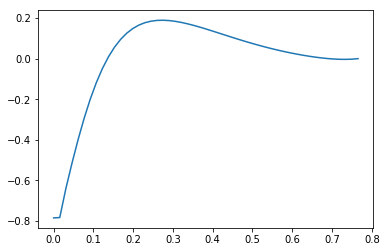

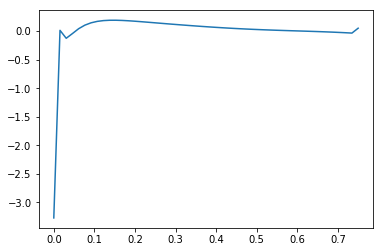

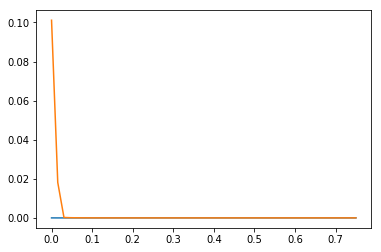

In [196]:
plt.plot(time_array, traj[:,0])
plt.show()
plt.plot(time_array[:-1], input_traj[:])
plt.show()
plt.plot(time_array[:-1], force_traj[:])
plt.show()

In [195]:
# code to simulate passive dynamics
sec = 1.0 # seconds
steps_per_sec = 1000.0 # discrete steps in a second
num_steps = sec*steps_per_sec # total number of steps
sec_per_step = sec/num_steps # number of seconds per step
for t in np.linspace(0,sec,num_steps):
    
    # update state
    # no input
    this_dt = sec_per_step
    torque = [0.0]
    force = [0,0]
    current_state += pivot_dynamics(current_state,torque, force)*this_dt#     print(current_state[11])
    # update the state of the cart
    draw_transformation(current_state)
    time.sleep(sec_per_step)

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  
